In [1]:
import cv2
import numpy as np
import theano
import theano.tensor as tensor
import lasagne
import matplotlib.pyplot as plt
import os
from lasagne.layers import (batch_norm, Conv2DLayer, Deconv2DLayer,
                            DropoutLayer, ReshapeLayer, InputLayer, DenseLayer, NonlinearityLayer)
from lasagne.layers.pool import MaxPool2DLayer, Upscale2DLayer
from lasagne.nonlinearities import softmax, sigmoid, rectify
from IPython.display import display, Image as im
from PIL import Image
from resizeimage import resizeimage

rect = lasagne.nonlinearities.rectify


Using cuDNN version 5005 on context None
Preallocating 4319/4799 Mb (0.900000) on cuda0
Mapped name None to device cuda0: Tesla K20m (0000:20:00.0)


In [ ]:
%load_ext autoreload


The cell below has some of Lasagne Layers. The DConv2D has been borrowed from Jan Schütler's gist. I did some experiments with changing the transpose convolution to other upsampling methods. This was trained initially on GPUs given by FloydHub, which uses older version of Lasagne. Hence have borrowed some code(by copy pasting) from Lasagne. 

In [6]:
from theano.tensor.nnet.abstract_conv import bilinear_upsampling
lr = lasagne.nonlinearities.LeakyRectify(leakiness=0.2)

class BilinearUpLayer(lasagne.layers.Layer):
    def __init__(self, incoming, ratio, nonlinearity=lr, **kwargs):
        super(BilinearUpLayer, self).__init__(incoming, **kwargs)
        self.incoming = incoming
        self.ratio = ratio    
        self.nonlinearity = nonlinearity
#         if (not isinstance(output_size, tensor.Variable) and output_size is not None):
#             if isinstance(output_size, tuple):
#                 output_size = output_size
#             elif isinstance(output_size, list):
#                 output_size = tuple(output_size)
#             elif isinstance(output_size, int):
#                 output_size = tuple([output_size, output_size])
#             else:
#                 raise
#         self.output_size = output_size
        
    def get_ouput_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2] * ratio, input_shape[3] * ratio)
    
    def get_output_for(self, input, deterministic=False, **kwargs):
        return self.nonlinearity(bilinear_upsampling(input, self.ratio, use_1D_kernel=False))


class SubpixelLayer(lasagne.layers.Layer):

    def __init__(self, incoming,r,c, nonlinearity=rect, **kwargs):
        super(SubpixelLayer, self).__init__(incoming, **kwargs)
        self.r=r # Upscale factor
        self.c=c # number of output channels
        self.nonlinearity = nonlinearity
        
    def get_output_shape_for(self, input_shape):
        return (input_shape[0],self.c,self.r*input_shape[2],self.r*input_shape[3])

    def get_output_for(self, input, deterministic=False, **kwargs):
        out = tensor.zeros((input.shape[0],self.output_shape[1],self.output_shape[2],self.output_shape[3]))
        for x in xrange(self.r): # loop across all feature maps belonging to this channel
            for y in xrange(self.r):
                out=tensor.set_subtensor(out[:,:,x::self.r,y::self.r],input[:,self.r*x+y::self.r*self.r,:,:])
        return self.nonlinearity(out)

class Dconv2DLayer(lasagne.layers.Layer):

    def __init__(self, incoming, num_filters, filter_size, stride=1, pad=0,
            nonlinearity=rect, **kwargs):
        super(Dconv2DLayer, self).__init__(incoming, **kwargs)
        self.num_filters = num_filters
        self.filter_size = lasagne.utils.as_tuple(filter_size, 2, int)
        self.stride = lasagne.utils.as_tuple(stride, 2, int)
        self.pad = lasagne.utils.as_tuple(pad, 2, int)
        self.W = self.add_param(lasagne.init.Normal(0.05),
                (self.input_shape[1], num_filters) + self.filter_size,
                name='W')
        self.b = self.add_param(lasagne.init.Constant(0),
                (num_filters,),
                name='b')
        if nonlinearity is None:
            nonlinearity = lasagne.nonlinearities.identity
        self.nonlinearity = nonlinearity

    def get_output_shape_for(self, input_shape):
        shape = tuple(i*s - 2*p + f - 1
                for i, s, p, f in zip(input_shape[2:],
                                      self.stride,
                                      self.pad,
                                      self.filter_size))
        return (input_shape[0], self.num_filters) + shape

    def get_output_for(self, input, **kwargs):
        op = tensor.nnet.abstract_conv.AbstractConv2d_gradInputs(
            imshp=self.output_shape,
            kshp=(self.input_shape[1], self.num_filters) + self.filter_size,
            subsample=self.stride, border_mode=self.pad)
        conved = op(self.W, input, self.output_shape[2:])
        if self.b is not None:
            conved += self.b.dimshuffle('x', 0, 'x', 'x')
        return self.nonlinearity(conved)

class DotLayer(lasagne.layers.Layer):
    def __init__(self, incoming, num_units, W=lasagne.init.Normal(0.01), nonlinearities=None, **kwargs):
        super(DotLayer, self).__init__(incoming, **kwargs)
        num_inputs = self.input_shape[1]
        self.num_units = num_units
        self.W = self.add_param(W, (num_inputs, num_units), name='W')
        self.nonlinearities = nonlinearities

    def get_output_for(self, input, **kwargs):
        return self.nonlinearities(tensor.dot(input, self.W))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_units)

In [7]:
# Unpickling and loading the data

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict
load_path = '/home/neena/Ramana/Dataset/cifar-100-python/train'
cifar_data = unpickle(load_path)

data
batch_label
fine_labels
coarse_labels
filenames
(50000, 3072)


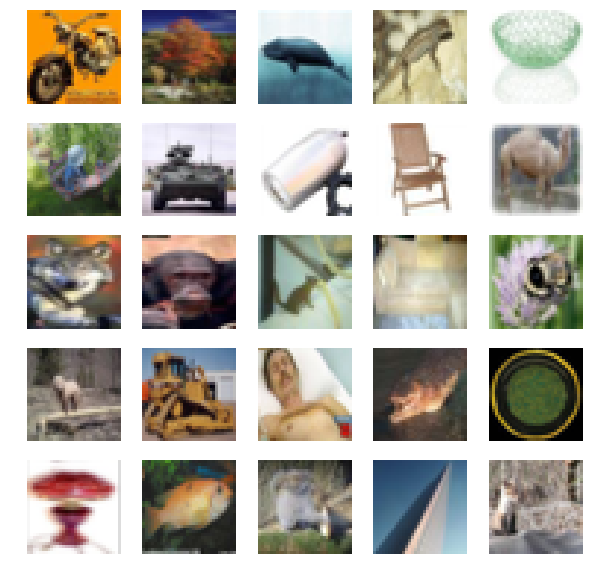

In [10]:
# Visualisation cell to visualise images 

from skimage import io
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import pylab
for k, v in cifar_data.items():
    print k
print cifar_data['data'].shape
reshaped_image = cifar_data['data'].reshape(50000, 3, 32, 32)
transposed_image = reshaped_image.transpose(0, 2, 3, 1)
fig, axes1 = plt.subplots(5, 5, figsize=(10, 10))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(reshaped_image)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(transposed_image[i:i+1][0])

In [11]:
w1 = lasagne.init.Normal(0.05)
from lasagne.layers.dense import NINLayer
from lasagne.layers.pool import GlobalPoolLayer

# The comments inside the method are to signify the spatial dimension of the image

def build_generator(inp):
    net0 = InputLayer((None, 100), input_var=inp)
    net1 = batch_norm(DenseLayer(net0, 4096, W=w1))
    net2 = ReshapeLayer(net1, ([0], 512, 4, 4))
    net3 = batch_norm(Dconv2DLayer(net2, 256, 5, stride=2, pad=2))
    # 8 * 8
    net4 = batch_norm(Dconv2DLayer(net3, 128, 5, stride=2, pad=2))
    # 16 * 16
    net5 = Dconv2DLayer(net4, 3, 5, stride=2, pad=2, nonlinearity=tanh)
    # 3 * 32 * 32
    return net5
    

def build_desc(inp):
    net0= DropoutLayer(InputLayer((None, 3, 32, 32), input_var=inp), p=0.2)
    # 32 * 32
    net10 = batch_norm(Conv2DLayer(net0, 96, 3, pad=1, W=w1, nonlinearity=lr))
    net11 = batch_norm(Conv2DLayer(net10, 96, 3, pad=1, W=w1, nonlinearity=lr))
    net1 = DropoutLayer(batch_norm(Conv2DLayer(net11, 96, 3, stride=2, pad=1, W=w1, nonlinearity=lr)), p=0.5)
    # 16 * 16
    net20 = batch_norm(Conv2DLayer(net1, 192, 3, pad=1, W=w1, nonlinearity=lr))
    net21 = batch_norm(Conv2DLayer(net20, 192, 3, pad=1, W=w1, nonlinearity=lr))
    net2 = DropoutLayer(batch_norm(Conv2DLayer(net21, 192, 3, stride=2, pad=1, W=w1, nonlinearity=lr)), p=0.5)
    # 8 * 8
    net3 = batch_norm(Conv2DLayer(net2, 192, 3, pad=0, W=w1, nonlinearity=lr))
    # 6 * 6
    net4 = batch_norm(NINLayer(net3, 192, W=w1, nonlinearity=lr))
    net5 = GlobalPoolLayer(net4)
    net6 = DenseLayer(net5, 1, nonlinearity=sigmoid)
    # 1
    return net6
    

In [ ]:
import time
from lasagne.objectives import binary_crossentropy
from lasagne.nonlinearities import tanh

initial_lr = 3e-04
l_r = theano.shared(np.float32(initial_lr))
batch_size = 100
batch_number = int(round(len(reshaped_image)/batch_size))
num_epochs = 200

noise_var = tensor.matrix('noise', dtype='float32')
x_inp = tensor.tensor4('x_inp', dtype='float32')


gen = build_generator(noise_var)
desc = build_desc(x_inp)

# Output of discriminator with original images
disc = lasagne.layers.get_output(desc)
# Output of Generator combined with discriminator. This for training Generator
disc_over_gen = lasagne.layers.get_output(desc, lasagne.layers.get_output(gen))

# Loss functions
# Objective for the discriminator is to catagorize generated image into class 0 and original to class 1
# Objective for the generator is to get it's image catagorized as 1

generator_loss = binary_crossentropy(disc_over_gen, tensor.ones_like(disc_over_gen)).mean()
discriminator_loss = (binary_crossentropy(disc, tensor.ones_like(disc)) + 
                      binary_crossentropy(disc_over_gen, tensor.zeros_like(disc_over_gen))).mean()
# Update params
gen_params = lasagne.layers.get_all_params(gen, trainable=True)
disc_params = lasagne.layers.get_all_params(desc, trainable=True)

# Gen updates
updates = lasagne.updates.adam(generator_loss, gen_params, beta1=0.5, learning_rate=l_r)
updates.update(lasagne.updates.adam(discriminator_loss, disc_params, beta1=0.5, 
                                    learning_rate=l_r))

# Compile theano functions
# Functions for training
print("Starting to compile functions")
train_func = theano.function([noise_var, x_inp], [(disc > 0.5).mean(), (disc_over_gen < 0.5).mean()],
                             updates=updates)
print("done compiling training functions")
# Functions for generating
generate_im_func = theano.function([noise_var], lasagne.layers.get_output(gen, deterministic=True))
print("done all compilation")

# This code below has been borrowed and altered from f0k's gists

for ep in range(num_epochs):
    # create batches problematicand train
    # Batch size is 128, so 220
    gan_loss = []
    disc_loss = []
    begin = time.time()
    offset = 0
    loss = 0
    for num_iter, bn in enumerate(range(batch_number)):
        inputs = reshaped_image[offset:offset + batch_size] / np.float32(127.5) - 1

        noise = lasagne.utils.floatX(np.random.randn(batch_size, 100))
        loss += np.array(train_func(noise, inputs))
        offset += batch_size
    end = time.time()
    print("DC GAN loss is " + str(loss / np.float32(batch_number)))
    print("Finished {} of {}. Time taken {:.3f}s".format(ep + 1, num_epochs,  end - begin))
    # plotting image
    generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(10, 100)))
    plt.imshow(generated_image.transpose(0, 2, 3, 1)[0])
    plt.figure(1)

# generated_image = generate_im_func(lasagne.utils.floatX(np.random.rand(1, 100)))
# plt.imshow(generated_image[0].transpose(1, 2, 0))
# plt.figure(1)